In [1]:
!pip install pydub --quiet

In [2]:
import os
import pickle
import librosa

import numpy as np
import matplotlib.pyplot as plt

import pydub as pyd
import IPython.display as ipd

import tensorflow as tf

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [29]:
json_file = open('/content/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("/content/best_model.weights.h5")

with open('/content/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

with open('/content/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)

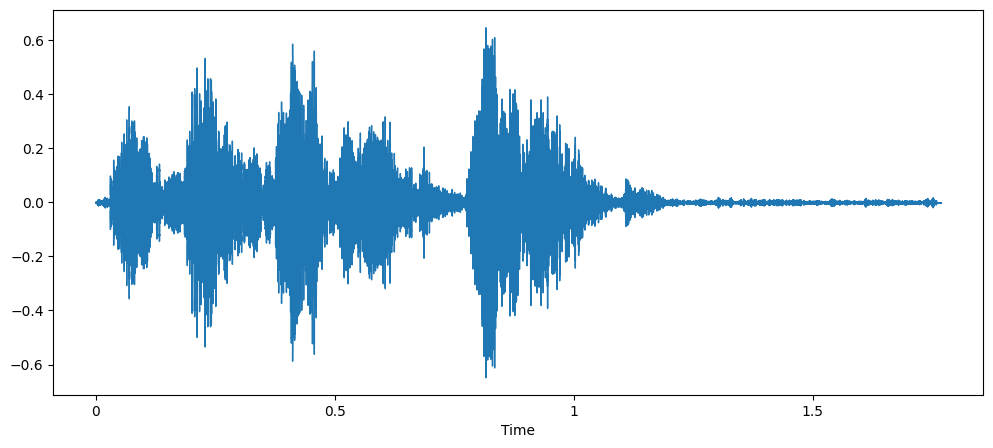

In [24]:
audio = "/content/audio.wav"
audio_data, audio_sr = librosa.load(audio)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=audio_data, sr=audio_sr);

In [25]:
ipd.Audio(audio_data, rate=audio_sr)

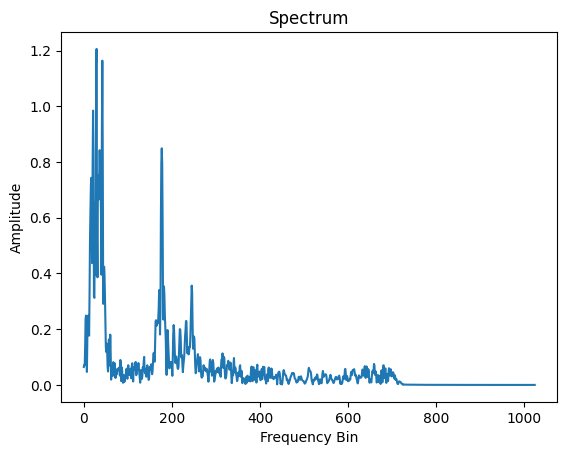

In [26]:
n_fft = 2048
D = np.abs(librosa.stft(audio_data[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');
plt.plot(D);

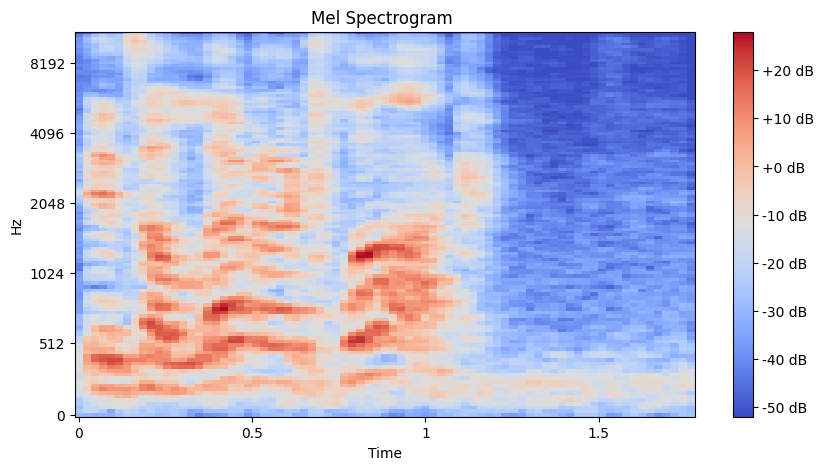

In [27]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=audio_sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=audio_sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

In [22]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

def extract_spectrogram_features(data, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return np.ravel(log_spectrogram)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
         zcr(data,frame_length,hop_length),
         rmse(data,frame_length,hop_length),
         mfcc(data,sr,frame_length,hop_length),
         extract_spectrogram_features(data, sr)
        ))

    return result

In [15]:
def get_predict_feat(path, expected_shape=(1, 500)):
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d)

    if res.shape != expected_shape:
        flat_size = np.prod(expected_shape)
        if res.size < flat_size:
            # Pad if the size is smaller than expected
            pad_width = (0, flat_size - res.size)
            res = np.pad(res, pad_width=pad_width, mode='constant')
        else:
            # Resize if the size is larger than expected
            res = np.resize(res, expected_shape)

    i_result = scaler.transform(res.reshape(1, -1))
    final_result = np.expand_dims(i_result, axis=2)

    return final_result

In [16]:
def prediction(path1):
    res = get_predict_feat(path1)
    predictions = loaded_model.predict(res)

    label_names = list(encoder.categories_[0])

    # Get the index of the label with the highest confidence score
    predicted_label_index = np.argmax(predictions)

    # List to store confidence scores
    confidence_scores = []

    # Display predicted emotion and confidence for each label
    print(f"\nPredicted Emotion: {label_names[predicted_label_index]}")
    for label_index, label_name in enumerate(label_names):
        confidence_score = predictions[0][label_index]
        confidence_score = 0 if confidence_score < 0.001 else confidence_score
        confidence_scores.append({'label': label_name, 'confidence': confidence_score})

    print("\n")

    sorted_confidence_scores = sorted(confidence_scores, key=lambda x: x['confidence'], reverse=True)

    return sorted_confidence_scores

In [30]:
prediction(audio)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step

Predicted Emotion: happy




[{'label': 'happy', 'confidence': np.float32(1.0)},
 {'label': 'angry', 'confidence': 0},
 {'label': 'disgust', 'confidence': 0},
 {'label': 'fear', 'confidence': 0},
 {'label': 'neutral', 'confidence': 0},
 {'label': 'sad', 'confidence': 0},
 {'label': 'surprise', 'confidence': 0}]

In [32]:
import os

audio_directory = "/content/audio_files"

if os.path.isdir(audio_directory):
    audio_files = [f for f in os.listdir(audio_directory) if f.endswith('.wav')]

    if audio_files:
        print(f"Processing audio files in {audio_directory}:")
        for audio_file in audio_files:
            file_path = os.path.join(audio_directory, audio_file)
            print(f"\nProcessing file: {audio_file}")
            predictions = prediction(file_path)
    else:
        print(f"No audio files found in {audio_directory}")
else:
    print(f"Directory not found: {audio_directory}")

Processing audio files in /content/audio_files:

Processing file: happy1.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

Predicted Emotion: happy



Processing file: happy2.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

Predicted Emotion: happy



Processing file: angry.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

Predicted Emotion: happy


